# Import library

In [1]:
import os
import os, sys
import glob
import re
import datetime
from datetime import datetime, timedelta 
import math, copy, time
from itertools import cycle
from collections import defaultdict

from parse import parse
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# import torchvision
# import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import svm


from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn

%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option("display.max_column", 100)

In [3]:
# Util functions
def size_and_ratio(df, col, dropna=True):
    if pd.__version__ > '1.1':
        sr = df.groupby(col, dropna=dropna).size().sort_values(ascending=False)
    elif dropna:
        sr = df.groupby(col).size().sort_values(ascending=False)
    else:  # dropna == False
        sr = df.fillna('nan').groupby(col).size().sort_values(ascending=False)
    sr_ratio = sr.copy() / sum(sr)
    print("Sum :", sum(sr), sr.shape)
    sr.name = 'size'
    sr_ratio.name = 'ratio'
    return pd.concat([sr, sr_ratio], axis=1)

# Data load

In [4]:
df_train = pd.read_csv("data/df_data_v3_1/df_train_v3_1.csv")
df_val = pd.read_csv("data/df_data_v3_1/df_valid_v3_1.csv")
df_test = pd.read_csv("data/df_data_v3_1/df_test_v3_1.csv")
print(df_train.shape, df_val.shape, df_test.shape)
df_train.head()

(14093, 24) (4647, 24) (4586, 24)


,baby_id,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,pcr_result
0,21099,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0.173311,0.007956,0.012987,1,0.0,0.18,3,0
1,21151,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0.179009,0.008614,0.013084,1,0.0,0.17,4,0
2,21024,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.179009,0.008614,0.013084,1,1.0,0.29,4,0
3,21176,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.131500,0.008252,0.000000,0,0.0,0.40,5,0
4,4467,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.131500,0.008252,0.000000,0,1.0,0.34,5,0


In [5]:
import random
print("Train:", df_train.shape, df_train['baby_id'].nunique())
print("Validaiton:", df_val.shape, df_val['baby_id'].nunique())

Train: (14093, 24) 9641
Validaiton: (4647, 24) 3213


## Remove baby_id and results

In [6]:
exclude_cols = ['baby_id', 'pcr_result']
cols = [x for x in df_train.columns if x not in exclude_cols]

df_train_gt = df_train[['pcr_result']]
df_train_input = df_train[cols]
df_val_gt = df_val[['pcr_result']]
df_val_input = df_val[cols]
df_test_gt = df_test[['pcr_result']]
df_test_input = df_test[cols]


In [7]:
df_trainval = pd.concat([df_train, df_val], axis=0)
print(df_trainval.shape)


(18740, 24)


In [8]:
size_and_ratio(df_trainval, 'pcr_result')

Sum : 18740 (2,)


,size,ratio
pcr_result,,
1,13478,0.71921
0,5262,0.28079


In [9]:
size_and_ratio(df_test, 'pcr_result')

Sum : 4586 (2,)


,size,ratio
pcr_result,,
1,3332,0.726559
0,1254,0.273441


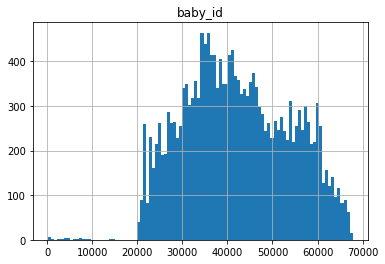

In [10]:
df_trainval.hist('baby_id', bins=100)
plt.show()

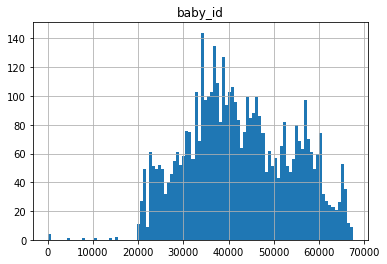

In [11]:
df_test.hist('baby_id',bins=100)
plt.show()

In [12]:
print(df_trainval['baby_id'].nunique(), df_test['baby_id'].nunique())

12854 3214


# Check Logistic regression performance

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def run_one_full_train_test(df_trainval, df_test, cols, model):
    x = df_trainval[cols]
    y = df_trainval['pcr_result']
    print(f"start to train: x.shape:{x.shape}, y.shape:{y.shape}")

    model.fit(x, y)
    print(f"Model: {model}")
    if getattr(model, 'predict_proba', False):
        print("Found predict_proba")
        pred_raw = model.predict_proba(df_trainval[cols])
        pred_pos = np.array([x[1] for x in pred_raw])
    else:
        pred_pos = model.predict(df_trainval[cols])
    
    gt = df_trainval['pcr_result']

    print(pred_pos.shape, gt.shape)
    print("train set auc", roc_auc_score(gt, pred_pos))

    if getattr(model, 'predict_proba', False):
        pred_raw = model.predict_proba(df_test[cols])
        pred_pos = np.array([x[1] for x in pred_raw])
    else:
        pred_pos = model.predict(df_test[cols])
    
    gt = df_test['pcr_result']
    test_result = roc_auc_score(gt, pred_pos)
    print("test set auc", test_result)
        
    return model, test_result

lr_model = LogisticRegression()

run_one_full_train_test(df_trainval, df_test, cols, lr_model)

start to train: x.shape:(18740, 22), y.shape:(18740,)
Model: LogisticRegression()
Found predict_proba
(18740,) (18740,)
train set auc 0.849256568230142
train set auc 0.8383881064387477


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(LogisticRegression(), 0.8383881064387477)

## repeat 5 times

In [169]:
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        lr_model
    )

start to train: x.shape:(14992, 22), y.shape:(14992,)
Model: LogisticRegression()
Found predict_proba
(14992,) (14992,)
train set auc 0.8529035027646228
train set auc 0.838625043318763
start to train: x.shape:(14992, 22), y.shape:(14992,)


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Model: LogisticRegression()
Found predict_proba
(14992,) (14992,)
train set auc 0.8471471528407548
train set auc 0.8381056968241842
start to train: x.shape:(14992, 22), y.shape:(14992,)
Model: LogisticRegression()
Found predict_proba
(14992,) (14992,)
train set auc 0.8489024277242401
train set auc 0.838121731946367
start to train: x.shape:(14992, 22), y.shape:(14992,)


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Model: LogisticRegression()
Found predict_proba
(14992,) (14992,)
train set auc 0.8453316982771265
train set auc 0.8381724699449158
start to train: x.shape:(14992, 22), y.shape:(14992,)
Model: LogisticRegression()
Found predict_proba
(14992,) (14992,)
train set auc 0.8461592444966044
train set auc 0.8386626181573107


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [170]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.838625043318763, 1: 0.8381056968241842, 2: 0.838121731946367, 3: 0.8381724699449158, 4: 0.8386626181573107}
mean: 0.8383375120383081 std: 0.0002513588908400427


### Use xgboost

In [171]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [172]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [173]:

run_one_full_train_test(df_trainval, df_test, cols, xg_reg)

start to train: x.shape:(18740, 22), y.shape:(18740,)
[19:30:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', ...)
(18740,) (18740,)
train set 

(XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='reg:linear', ...),
 0.830604131604795)

In [175]:
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        xg_reg
    )

start to train: x.shape:(14992, 22), y.shape:(14992,)
[19:30:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', ...)
(14992,) (14992,)
train set 

In [176]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.8304989459898792, 1: 0.8283381534431956, 2: 0.8300372780691224, 3: 0.8290787606908792, 4: 0.8294619283119947}
mean: 0.8294830133010143 std: 0.0007501863108692136


### LGBM

In [182]:
import lightgbm as lgb

In [178]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        lgb_model
    )

start to train: x.shape:(14992, 22), y.shape:(14992,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14992,) (14992,)
train set auc 0.9139740018570103
train set auc 0.8472786243684077
start to train: x.shape:(14992, 22), y.shape:(14992,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14992,) (14992,)
train set auc 0.9093282452222899
train set auc 0.8440041088205618
start to train: x.shape:(14992, 22), y.shape:(14992,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14992,) (14992,)
train set auc 0.9122993112181863
train set auc 0.8467651414632839
start to train: x.shape:(14992, 22), y.shape:(14992,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14992,) (14992,)
train set auc 0.9089411193776726
train set auc 0.8452445571530047
start to train: x.shape:(14992, 22), y.shape:(14992,)
Model: LGBMClassifier(

In [179]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.8472786243684077, 1: 0.8440041088205618, 2: 0.8467651414632839, 3: 0.8452445571530047, 4: 0.8453708038239218}
mean: 0.8457326471258361 std: 0.0011673129195661717


## TabNet

In [180]:
import pandas as pd
import numpy  as np
from tqdm.auto import tqdm
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import torch

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


start to train: x_train.shape:(7496, 22), y_train.shape:(7496,)
start to train: x_val.shape:(1874, 22), y_val.shape:(1874,)
y_train mean:0.7174493062966916. y_val mean:0.7118463180362861
epoch 0  | loss: 0.69268 | train_auc: 0.53499 | valid_auc: 0.52151 |  0:00:00s
epoch 2  | loss: 0.49088 | train_auc: 0.64811 | valid_auc: 0.64805 |  0:00:02s
epoch 4  | loss: 0.45949 | train_auc: 0.71413 | valid_auc: 0.71036 |  0:00:04s
epoch 6  | loss: 0.4389  | train_auc: 0.67799 | valid_auc: 0.67464 |  0:00:05s
epoch 8  | loss: 0.43326 | train_auc: 0.71618 | valid_auc: 0.72723 |  0:00:07s
epoch 10 | loss: 0.4256  | train_auc: 0.73286 | valid_auc: 0.73602 |  0:00:08s
epoch 12 | loss: 0.42665 | train_auc: 0.75132 | valid_auc: 0.75345 |  0:00:09s
epoch 14 | loss: 0.42617 | train_auc: 0.79667 | valid_auc: 0.80656 |  0:00:11s
epoch 16 | loss: 0.42077 | train_auc: 0.80482 | valid_auc: 0.81248 |  0:00:12s
epoch 18 | loss: 0.41756 | train_auc: 0.81207 | valid_auc: 0.82365 |  0:00:14s
epoch 20 | loss: 0.4151

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


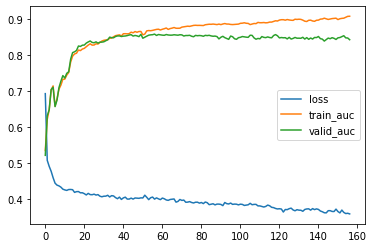

y_val.head:[1 1 0 1 1]
BEST AUC SCORE ON VALIDATION SET : 0.8578592648120384
start to test: x_test.shape:(4586, 22), y_test.shape:(4586,)


array([8.19890322e-02, 2.91435020e-02, 1.11333044e-01, 5.16517743e-02,
       4.30659322e-02, 6.80885324e-02, 4.71671498e-03, 1.30531696e-02,
       6.04307339e-02, 5.51238781e-02, 1.45590741e-01, 2.36497617e-02,
       1.73333839e-02, 5.91865342e-04, 7.92322157e-03, 4.55345700e-02,
       1.51826284e-01, 2.49395253e-02, 1.51220416e-04, 4.66986155e-05,
       7.20948074e-05, 6.37443205e-02])

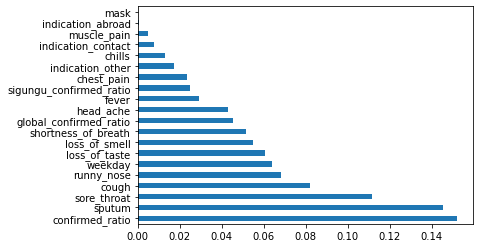

preds_test head:[[0.66228783 0.33771214]
 [0.7375122  0.26248777]
 [0.72635597 0.27364403]
 [0.61716497 0.38283503]
 [0.546746   0.45325395]]
BEST AUC SCORE ON TEST SET : 0.8299095954171143
Best epoch:56
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0056.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0056.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0056.pth
start to train: x_train.shape:(7496, 22), y_train.shape:(7496,)
start to train: x_val.shape:(1874, 22), y_val.shape:(1874,)
y_train mean:0.7226520811099253. y_val mean:0.7118463180362861


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69332 | train_auc: 0.5618  | valid_auc: 0.57075 |  0:00:00s
epoch 2  | loss: 0.47209 | train_auc: 0.77577 | valid_auc: 0.77227 |  0:00:03s
epoch 4  | loss: 0.45377 | train_auc: 0.7992  | valid_auc: 0.80979 |  0:00:04s
epoch 6  | loss: 0.44022 | train_auc: 0.79565 | valid_auc: 0.80915 |  0:00:06s
epoch 8  | loss: 0.43019 | train_auc: 0.79619 | valid_auc: 0.81123 |  0:00:08s
epoch 10 | loss: 0.42319 | train_auc: 0.80449 | valid_auc: 0.817   |  0:00:10s
epoch 12 | loss: 0.42033 | train_auc: 0.81064 | valid_auc: 0.81781 |  0:00:11s
epoch 14 | loss: 0.41872 | train_auc: 0.81748 | valid_auc: 0.82508 |  0:00:13s
epoch 16 | loss: 0.41337 | train_auc: 0.81738 | valid_auc: 0.82841 |  0:00:15s
epoch 18 | loss: 0.41101 | train_auc: 0.82574 | valid_auc: 0.83361 |  0:00:16s
epoch 20 | loss: 0.41044 | train_auc: 0.82997 | valid_auc: 0.8342  |  0:00:18s
epoch 22 | loss: 0.4096  | train_auc: 0.83208 | valid_auc: 0.8374  |  0:00:20s
epoch 24 | loss: 0.41059 | train_auc: 0.83356 | vali

epoch 208| loss: 0.34523 | train_auc: 0.91603 | valid_auc: 0.83265 |  0:03:03s
epoch 210| loss: 0.34826 | train_auc: 0.9136  | valid_auc: 0.83651 |  0:03:05s
epoch 212| loss: 0.35418 | train_auc: 0.91149 | valid_auc: 0.83351 |  0:03:07s
epoch 214| loss: 0.34998 | train_auc: 0.91506 | valid_auc: 0.84276 |  0:03:09s
epoch 216| loss: 0.3413  | train_auc: 0.91572 | valid_auc: 0.83224 |  0:03:11s
epoch 218| loss: 0.34341 | train_auc: 0.91912 | valid_auc: 0.8327  |  0:03:13s
epoch 220| loss: 0.34547 | train_auc: 0.91531 | valid_auc: 0.83372 |  0:03:15s

Early stopping occurred at epoch 220 with best_epoch = 120 and best_valid_auc = 0.8598


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=22, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


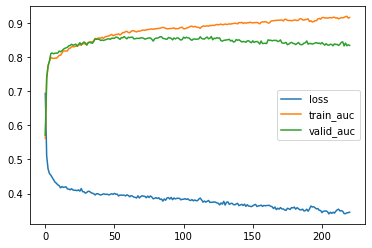

y_val.head:[0 1 0 0 1]
BEST AUC SCORE ON VALIDATION SET : 0.8598013493253374
start to test: x_test.shape:(4586, 22), y_test.shape:(4586,)


array([8.98482971e-02, 6.92239009e-02, 4.04541044e-02, 7.90495954e-03,
       8.82356935e-02, 2.70997154e-02, 3.85178150e-02, 2.58978173e-02,
       3.68196989e-02, 1.64496910e-02, 8.77105540e-02, 7.34876672e-03,
       1.04341596e-02, 5.89869393e-03, 6.79785149e-03, 8.04814898e-02,
       1.46003233e-01, 1.80985648e-05, 1.00200553e-01, 5.44936772e-02,
       2.51571997e-02, 3.50040304e-02])

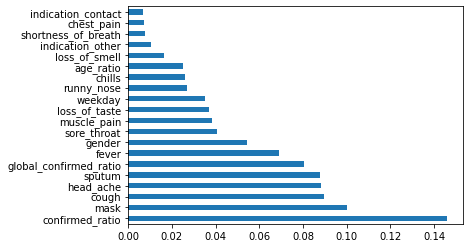

preds_test head:[[0.9408746  0.05912547]
 [0.68785536 0.3121446 ]
 [0.63568217 0.36431783]
 [0.7321817  0.26781833]
 [0.83739287 0.16260721]]
BEST AUC SCORE ON TEST SET : 0.8266923994478175
Best epoch:120
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0120.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0120.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0120.pth
start to train: x_train.shape:(7496, 22), y_train.shape:(7496,)
start to train: x_val.shape:(1874, 22), y_val.shape:(1874,)
y_train mean:0.7202508004268944. y_val mean:0.7299893276414088


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67307 | train_auc: 0.47067 | valid_auc: 0.46621 |  0:00:01s
epoch 2  | loss: 0.4851  | train_auc: 0.67565 | valid_auc: 0.67943 |  0:00:02s
epoch 4  | loss: 0.46602 | train_auc: 0.73829 | valid_auc: 0.74772 |  0:00:04s
epoch 6  | loss: 0.45325 | train_auc: 0.75546 | valid_auc: 0.75556 |  0:00:05s
epoch 8  | loss: 0.44614 | train_auc: 0.79473 | valid_auc: 0.79595 |  0:00:07s
epoch 10 | loss: 0.43428 | train_auc: 0.8075  | valid_auc: 0.8114  |  0:00:09s
epoch 12 | loss: 0.42961 | train_auc: 0.81369 | valid_auc: 0.81628 |  0:00:11s
epoch 14 | loss: 0.42652 | train_auc: 0.81084 | valid_auc: 0.82078 |  0:00:13s
epoch 16 | loss: 0.42757 | train_auc: 0.81094 | valid_auc: 0.82736 |  0:00:15s
epoch 18 | loss: 0.4296  | train_auc: 0.81272 | valid_auc: 0.82127 |  0:00:16s
epoch 20 | loss: 0.42479 | train_auc: 0.81831 | valid_auc: 0.82125 |  0:00:18s
epoch 22 | loss: 0.4205  | train_auc: 0.826   | valid_auc: 0.83094 |  0:00:20s
epoch 24 | loss: 0.42339 | train_auc: 0.82595 | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


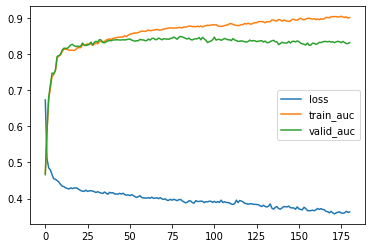

y_val.head:[1 1 1 1 0]
BEST AUC SCORE ON VALIDATION SET : 0.8490063680281071
start to test: x_test.shape:(4586, 22), y_test.shape:(4586,)


array([1.47924411e-01, 3.58034020e-02, 9.48853158e-02, 3.67165350e-03,
       3.04909736e-02, 1.11293019e-01, 1.00751324e-03, 8.22197955e-03,
       2.98278338e-02, 9.39826311e-02, 5.78949237e-02, 1.73296550e-06,
       5.79966244e-02, 2.01184973e-05, 8.89036612e-03, 6.52687952e-02,
       1.53160644e-01, 1.32352891e-02, 3.77640532e-02, 4.21683799e-03,
       2.72857640e-02, 1.71561188e-02])

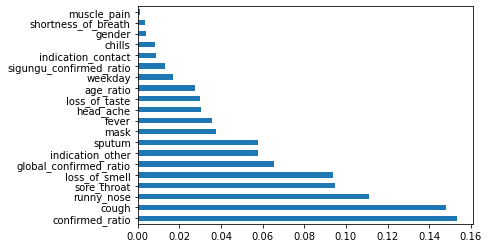

preds_test head:[[0.7540891  0.24591093]
 [0.87220305 0.12779702]
 [0.85246634 0.14753363]
 [0.8659547  0.1340453 ]
 [0.6801608  0.31983912]]
BEST AUC SCORE ON TEST SET : 0.8363573898458905
Best epoch:80
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0080.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0080.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0080.pth
start to train: x_train.shape:(7496, 22), y_train.shape:(7496,)
start to train: x_val.shape:(1874, 22), y_val.shape:(1874,)
y_train mean:0.7145144076840982. y_val mean:0.7182497331910352


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68003 | train_auc: 0.61264 | valid_auc: 0.58366 |  0:00:00s
epoch 2  | loss: 0.49003 | train_auc: 0.74643 | valid_auc: 0.73199 |  0:00:02s
epoch 4  | loss: 0.45724 | train_auc: 0.8033  | valid_auc: 0.79731 |  0:00:03s
epoch 6  | loss: 0.4466  | train_auc: 0.81048 | valid_auc: 0.80103 |  0:00:05s
epoch 8  | loss: 0.44319 | train_auc: 0.80598 | valid_auc: 0.79356 |  0:00:07s
epoch 10 | loss: 0.43348 | train_auc: 0.80699 | valid_auc: 0.79768 |  0:00:08s
epoch 12 | loss: 0.43049 | train_auc: 0.81448 | valid_auc: 0.80754 |  0:00:10s
epoch 14 | loss: 0.42772 | train_auc: 0.81737 | valid_auc: 0.8089  |  0:00:11s
epoch 16 | loss: 0.4247  | train_auc: 0.82468 | valid_auc: 0.81476 |  0:00:13s
epoch 18 | loss: 0.42656 | train_auc: 0.82563 | valid_auc: 0.81748 |  0:00:14s
epoch 20 | loss: 0.42757 | train_auc: 0.82741 | valid_auc: 0.81883 |  0:00:16s
epoch 22 | loss: 0.42228 | train_auc: 0.82917 | valid_auc: 0.81921 |  0:00:17s
epoch 24 | loss: 0.42299 | train_auc: 0.83591 | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


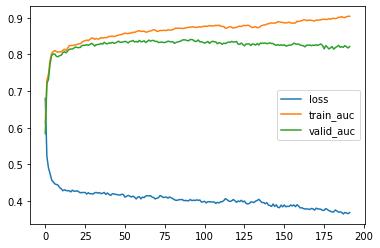

y_val.head:[1 1 1 1 0]
BEST AUC SCORE ON VALIDATION SET : 0.840928086586519
start to test: x_test.shape:(4586, 22), y_test.shape:(4586,)


array([8.63548456e-02, 4.35794598e-02, 1.21022620e-01, 1.51627731e-02,
       2.93920836e-02, 2.72375857e-02, 1.63545771e-02, 3.68653661e-02,
       2.65529163e-02, 2.81009174e-02, 1.24012162e-01, 5.83566393e-02,
       1.92370175e-04, 2.12336237e-02, 1.52815705e-03, 2.52066030e-02,
       2.59635272e-01, 1.70121827e-03, 2.81998563e-03, 1.57030702e-02,
       1.44324537e-02, 4.45553005e-02])

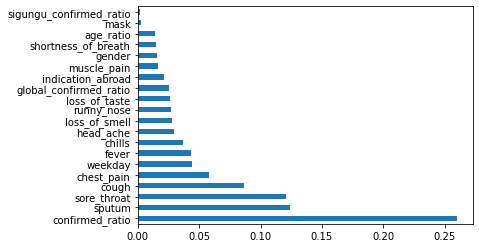

preds_test head:[[0.8449489  0.15505113]
 [0.8347692  0.16523086]
 [0.82473403 0.17526595]
 [0.9149397  0.08506031]
 [0.69968003 0.30032   ]]
BEST AUC SCORE ON TEST SET : 0.8356437072436631
Best epoch:91
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0091.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0091.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0091.pth
start to train: x_train.shape:(7496, 22), y_train.shape:(7496,)
start to train: x_val.shape:(1874, 22), y_val.shape:(1874,)
y_train mean:0.722385272145144. y_val mean:0.7113127001067235


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66193 | train_auc: 0.57412 | valid_auc: 0.58663 |  0:00:00s
epoch 2  | loss: 0.4851  | train_auc: 0.75179 | valid_auc: 0.75382 |  0:00:02s
epoch 4  | loss: 0.4612  | train_auc: 0.76586 | valid_auc: 0.74904 |  0:00:03s
epoch 6  | loss: 0.4493  | train_auc: 0.79796 | valid_auc: 0.7763  |  0:00:05s
epoch 8  | loss: 0.43775 | train_auc: 0.79882 | valid_auc: 0.77388 |  0:00:06s
epoch 10 | loss: 0.42941 | train_auc: 0.82114 | valid_auc: 0.7992  |  0:00:08s
epoch 12 | loss: 0.42392 | train_auc: 0.81982 | valid_auc: 0.80189 |  0:00:10s
epoch 14 | loss: 0.41987 | train_auc: 0.81806 | valid_auc: 0.80544 |  0:00:11s
epoch 16 | loss: 0.41641 | train_auc: 0.82154 | valid_auc: 0.81056 |  0:00:13s
epoch 18 | loss: 0.4155  | train_auc: 0.81536 | valid_auc: 0.8057  |  0:00:14s
epoch 20 | loss: 0.4156  | train_auc: 0.83365 | valid_auc: 0.82346 |  0:00:16s
epoch 22 | loss: 0.40994 | train_auc: 0.82821 | valid_auc: 0.81726 |  0:00:17s
epoch 24 | loss: 0.40412 | train_auc: 0.83605 | vali

epoch 208| loss: 0.35822 | train_auc: 0.90855 | valid_auc: 0.8263  |  0:02:52s
epoch 210| loss: 0.359   | train_auc: 0.90133 | valid_auc: 0.82298 |  0:02:53s

Early stopping occurred at epoch 210 with best_epoch = 110 and best_valid_auc = 0.84968
Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=22, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


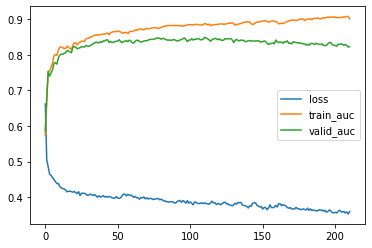

y_val.head:[0 1 1 1 1]
BEST AUC SCORE ON VALIDATION SET : 0.8496816902931833
start to test: x_test.shape:(4586, 22), y_test.shape:(4586,)


array([8.32147692e-02, 9.69377393e-02, 1.04870509e-01, 9.47144138e-02,
       8.71989790e-03, 3.91971992e-02, 1.24288059e-04, 3.84688202e-02,
       2.87961391e-02, 1.14432118e-02, 1.26981323e-01, 1.50592836e-02,
       2.28354652e-02, 3.70827884e-02, 0.00000000e+00, 0.00000000e+00,
       2.43164439e-01, 1.31129274e-02, 8.95424787e-03, 1.31401200e-05,
       2.63093980e-02, 0.00000000e+00])

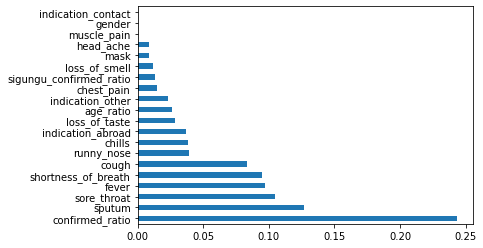

preds_test head:[[0.9747454  0.02525461]
 [0.8693075  0.13069248]
 [0.8818259  0.1181741 ]
 [0.8540124  0.14598759]
 [0.914753   0.08524698]]
BEST AUC SCORE ON TEST SET : 0.8373971598208662
Best epoch:110
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0110.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0110.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0110.pth


<Figure size 432x288 with 0 Axes>

In [166]:
def run_one_full_train_test_with_tabnet(df_trainval, df_test, cols, model):
    df_train, df_val = train_test_split(df_trainval, test_size=0.2)
    x_train = df_train[cols].to_numpy()
    y_train = df_train['pcr_result'].to_numpy()
    x_val = df_val[cols].to_numpy()
    y_val = df_val['pcr_result'].to_numpy()
    x_test = df_test[cols].to_numpy()
    y_test = df_test['pcr_result'].to_numpy()

    print(f"start to train: x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}")
    print(f"start to train: x_val.shape:{x_val.shape}, y_val.shape:{y_val.shape}")
    print(f"y_train mean:{np.mean(y_train)}. y_val mean:{np.mean(y_val)}")

    model.fit(
        X_train=x_train, y_train=y_train,
        eval_set=[(x_train, y_train), (x_val, y_val)],
        eval_name=['train', 'valid'],
#         patience=2, 
#         max_epochs=100,
        patience=100, 
        max_epochs=1000,
        eval_metric=['auc'],
    )
    
    print(f"Model: {model}")
    # plot losses
    plt.plot(model.history['loss'], label='loss')

    # plot accuracy
    plt.plot(model.history['train_auc'], label='train_auc')
    plt.plot(model.history['valid_auc'], label='valid_auc')
    plt.legend(['loss', 'train_auc', 'valid_auc'])
    plt.show()
    plt.clf()

    # determine best accuracy for validation set
    preds_valid = model.predict_proba(x_val)
    print(f"y_val.head:{y_val[:5]}")
    pred_pos = np.array([x[1] for x in preds_valid])
    valid_auc = roc_auc_score(y_val, pred_pos)
    print(f"BEST AUC SCORE ON VALIDATION SET : {valid_auc}")
    
    print(f"start to test: x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}")
    # find and plot feature importance
    y_pred = model.predict(x_test)
    feature_importances_ = model.feature_importances_
    display(feature_importances_)
    feat_importances = pd.Series(model.feature_importances_, index=cols)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()
    plt.clf()

    # determine best accuracy for test set
    preds = model.predict_proba(x_test)
    pred_pos = np.array([x[1] for x in preds])
    test_auc = roc_auc_score(y_test, pred_pos)
    print(f"preds_test head:{preds[:5]}")
    print(f"BEST AUC SCORE ON TEST SET : {test_auc}")
    
    config_name = 'TabNet_DEFAULT'
    best_epoch, element = max(enumerate(model.history['valid_auc']), key=lambda x: x[1])
    print(f"Best epoch:{best_epoch}")
    best_model = save_model(config_name, model, best_epoch)
    
    return model, test_auc

def save_model(config_name, model, epoch):
    save_path = f"./train_data/{model.__class__.__name__}_{config_name}_{epoch:04d}.pth"
    print("save_path", save_path)
    model.save_model(save_path)
    print("Success to save to : ", save_path)
    return model


test_result = dict()
models = dict()
for i in range(5):
    tab_model = TabNetClassifier(verbose = 2,seed = 1212)
    models[i], test_result[i] = run_one_full_train_test_with_tabnet(
        df_trainval, 
        df_test, cols,
        tab_model
    )
    

In [167]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.8299095954171143, 1: 0.8266923994478175, 2: 0.8363573898458905, 3: 0.8356437072436631, 4: 0.8373971598208662}
mean: 0.8332000503550703 std: 0.0041649152103427145
